In [1]:
import math
import os
import gc
import sys
import time
from pathlib import Path
from tqdm.notebook import tqdm

from numba import jit, njit

BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')

sys.path.insert(0, SRC_DIR)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch

from sample.reader import VideoReader

In [3]:
!ls $DATA_DIR

dfdc_train_part_0  dfdc_train_part_1


In [4]:
def show_image_bbox(img, boxes=None, figsize=(15,8)):
    plt.figure(figsize=figsize)
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='r', linewidth=1)
            if len(bbox) > 4:
                text = plt.text(
                    bbox[2]+10, bbox[1]-10, 
                    '%.02f' % bbox[4], color='r')
            plt.gca().add_patch(rect)
    plt.imshow(img)


def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [5]:
def read_labels(base_path):
    if not os.path.isdir(base_path):
        raise ValueError('Invalid data dir')
    chunk_dirs = os.listdir(base_path)
    labels = []
    for dir_name in chunk_dirs:
        path = os.path.join(base_path, dir_name, 'metadata.json')
        df = pd.read_json(path).T
        df['dir'] = dir_name
        df['label'] = (df['label'] == 'FAKE').astype(np.uint8)
        df.drop(['split'], axis=1, inplace=True)
        labels.append(df)
    return pd.concat(labels)

In [6]:
df = read_labels(DATA_DIR)
print(df.shape)
df.head()

(3033, 3)


label        original                dir
owxbbpjpch.mp4      1  wynotylpnm.mp4  dfdc_train_part_0
vpmyeepbep.mp4      0             NaN  dfdc_train_part_0
fzvpbrzssi.mp4      0             NaN  dfdc_train_part_0
htorvhbcae.mp4      1  wclvkepakb.mp4  dfdc_train_part_0
fckxaqjbxk.mp4      1  vpmyeepbep.mp4  dfdc_train_part_0

In [7]:
reader = VideoReader()

In [8]:
def get_sample(idx, labels_df, reader, n_frames=10, base_dir=DATA_DIR):
    row = labels_df.iloc[idx]
    file_path = os.path.join(base_dir, row.dir, row.name)
    sample, frames = reader.read_frames(file_path, n_frames)
    return sample


def get_text_label(idx, labels_df):
    label = labels_df.iloc[idx]['label']
    label = 'FAKE' if label else 'REAL'
    return label

In [9]:
sys.path.insert(0, os.path.join(BASE_DIR, 'Pytorch_Retinaface'))

In [10]:
from data import cfg_mnet
from layers.functions.prior_box import PriorBox
from models.retinaface import RetinaFace
from utils.box_utils import decode
from utils.nms.py_cpu_nms import py_cpu_nms

In [11]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [12]:
def decode_batch(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [n_samples, num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = torch.cat((
        priors[:, :2] + loc[:, :, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, :, 2:] * variances[1])), 2)
    boxes[:, :, :2] -= boxes[:, :, 2:] / 2
    boxes[:, :, 2:] += boxes[:, :, :2]
    return boxes


def prepare_imgs(sample, device):
    n, h, w, c = sample.shape
    
    imgs = np.float32(sample)
    imgs -= (104, 117, 123)
    imgs = imgs.transpose(0, 3, 1, 2)
    imgs = torch.from_numpy(imgs).to(device)

    scale = torch.tensor([w, h, w, h], device=device)
    return imgs, scale


def postproc_frame(boxes, scores, 
                   score_thresh=0.75, nms_thresh=0.4, 
                   top_k=500, keep_top_k=5):
    inds = (scores > score_thresh).nonzero()[0]
    boxes = boxes[inds]
    scores = scores[inds]

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_thresh)
    dets = dets[keep, :]

    # keep top-K faster NMS
    dets = dets[:keep_top_k, :]
    return dets


def postproc_detections(locations, confidence, priors, scale, resize=1):
    boxes = decode_batch(locations, priors, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = confidence.cpu().numpy()[:, :, 1]
    num_frames = scores.shape[0]
    dets = [postproc_frame(boxes[i], scores[i]) 
            for i in range(num_frames)]
    return dets

In [13]:
def detect(sample, model, cfg, device):
    num_frames, height, width, ch = sample.shape
    imgs, scale = prepare_imgs(sample, device)

    with torch.no_grad():
        loc, conf, landms = model(imgs)
    imgs, landms = None, None
    
    priorbox = PriorBox(cfg, image_size=(height, width))
    priors = priorbox.forward().to(device)

    dets = postproc_detections(loc, conf, priors, scale)
    return dets

In [14]:
@njit
def calc_axis(c0, c1, pad, cmax):
    c0 = max(0, c0 - pad)
    c1 = min(cmax, c1 + pad)
    return c0, c1, c1 - c0


@njit
def expand_bbox(bbox, pct):
    bbox = np.copy(bbox)
    bbox[:2] *= 1 - pct
    bbox[2:] *= 1 + pct
    return bbox


def crop_face(img, bbox, pad_pct=0.05, square=True):
    img_h, img_w, _ = img.shape
    
    if pad_pct > 0:
        bbox = expand_bbox(bbox, pad_pct)
        
    x0, y0, x1, y1 = bbox.astype(np.int16)
    
    if square:
        w, h = x1 - x0, y1 - y0
        if w > h:
            pad = (w - h) // 2
            y0, y1, h = calc_axis(y0, y1, pad, img_h)
        elif h > w:
            pad = (h - w) // 2
            x0, x1, w = calc_axis(x0, x1, pad, img_w)
        
    face = img[y0:y1, x0:x1]
    return face

In [15]:
rface_weights = os.path.join(BASE_DIR, 'data/weights/mobilenet0.25_Final.pth')
use_cpu = False

cfg = cfg_mnet
cfg['pretrain'] = False

net = RetinaFace(cfg=cfg, phase='test')
net = load_model(net, rface_weights, use_cpu)
net.eval()

'done'

Loading pretrained model from /home/dmitry/projects/dfdc/data/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


'done'

In [16]:
device = torch.device("cpu" if use_cpu else "cuda")
net = net.to(device)

In [17]:
i = -1

1: REAL
Avg size: 219.4


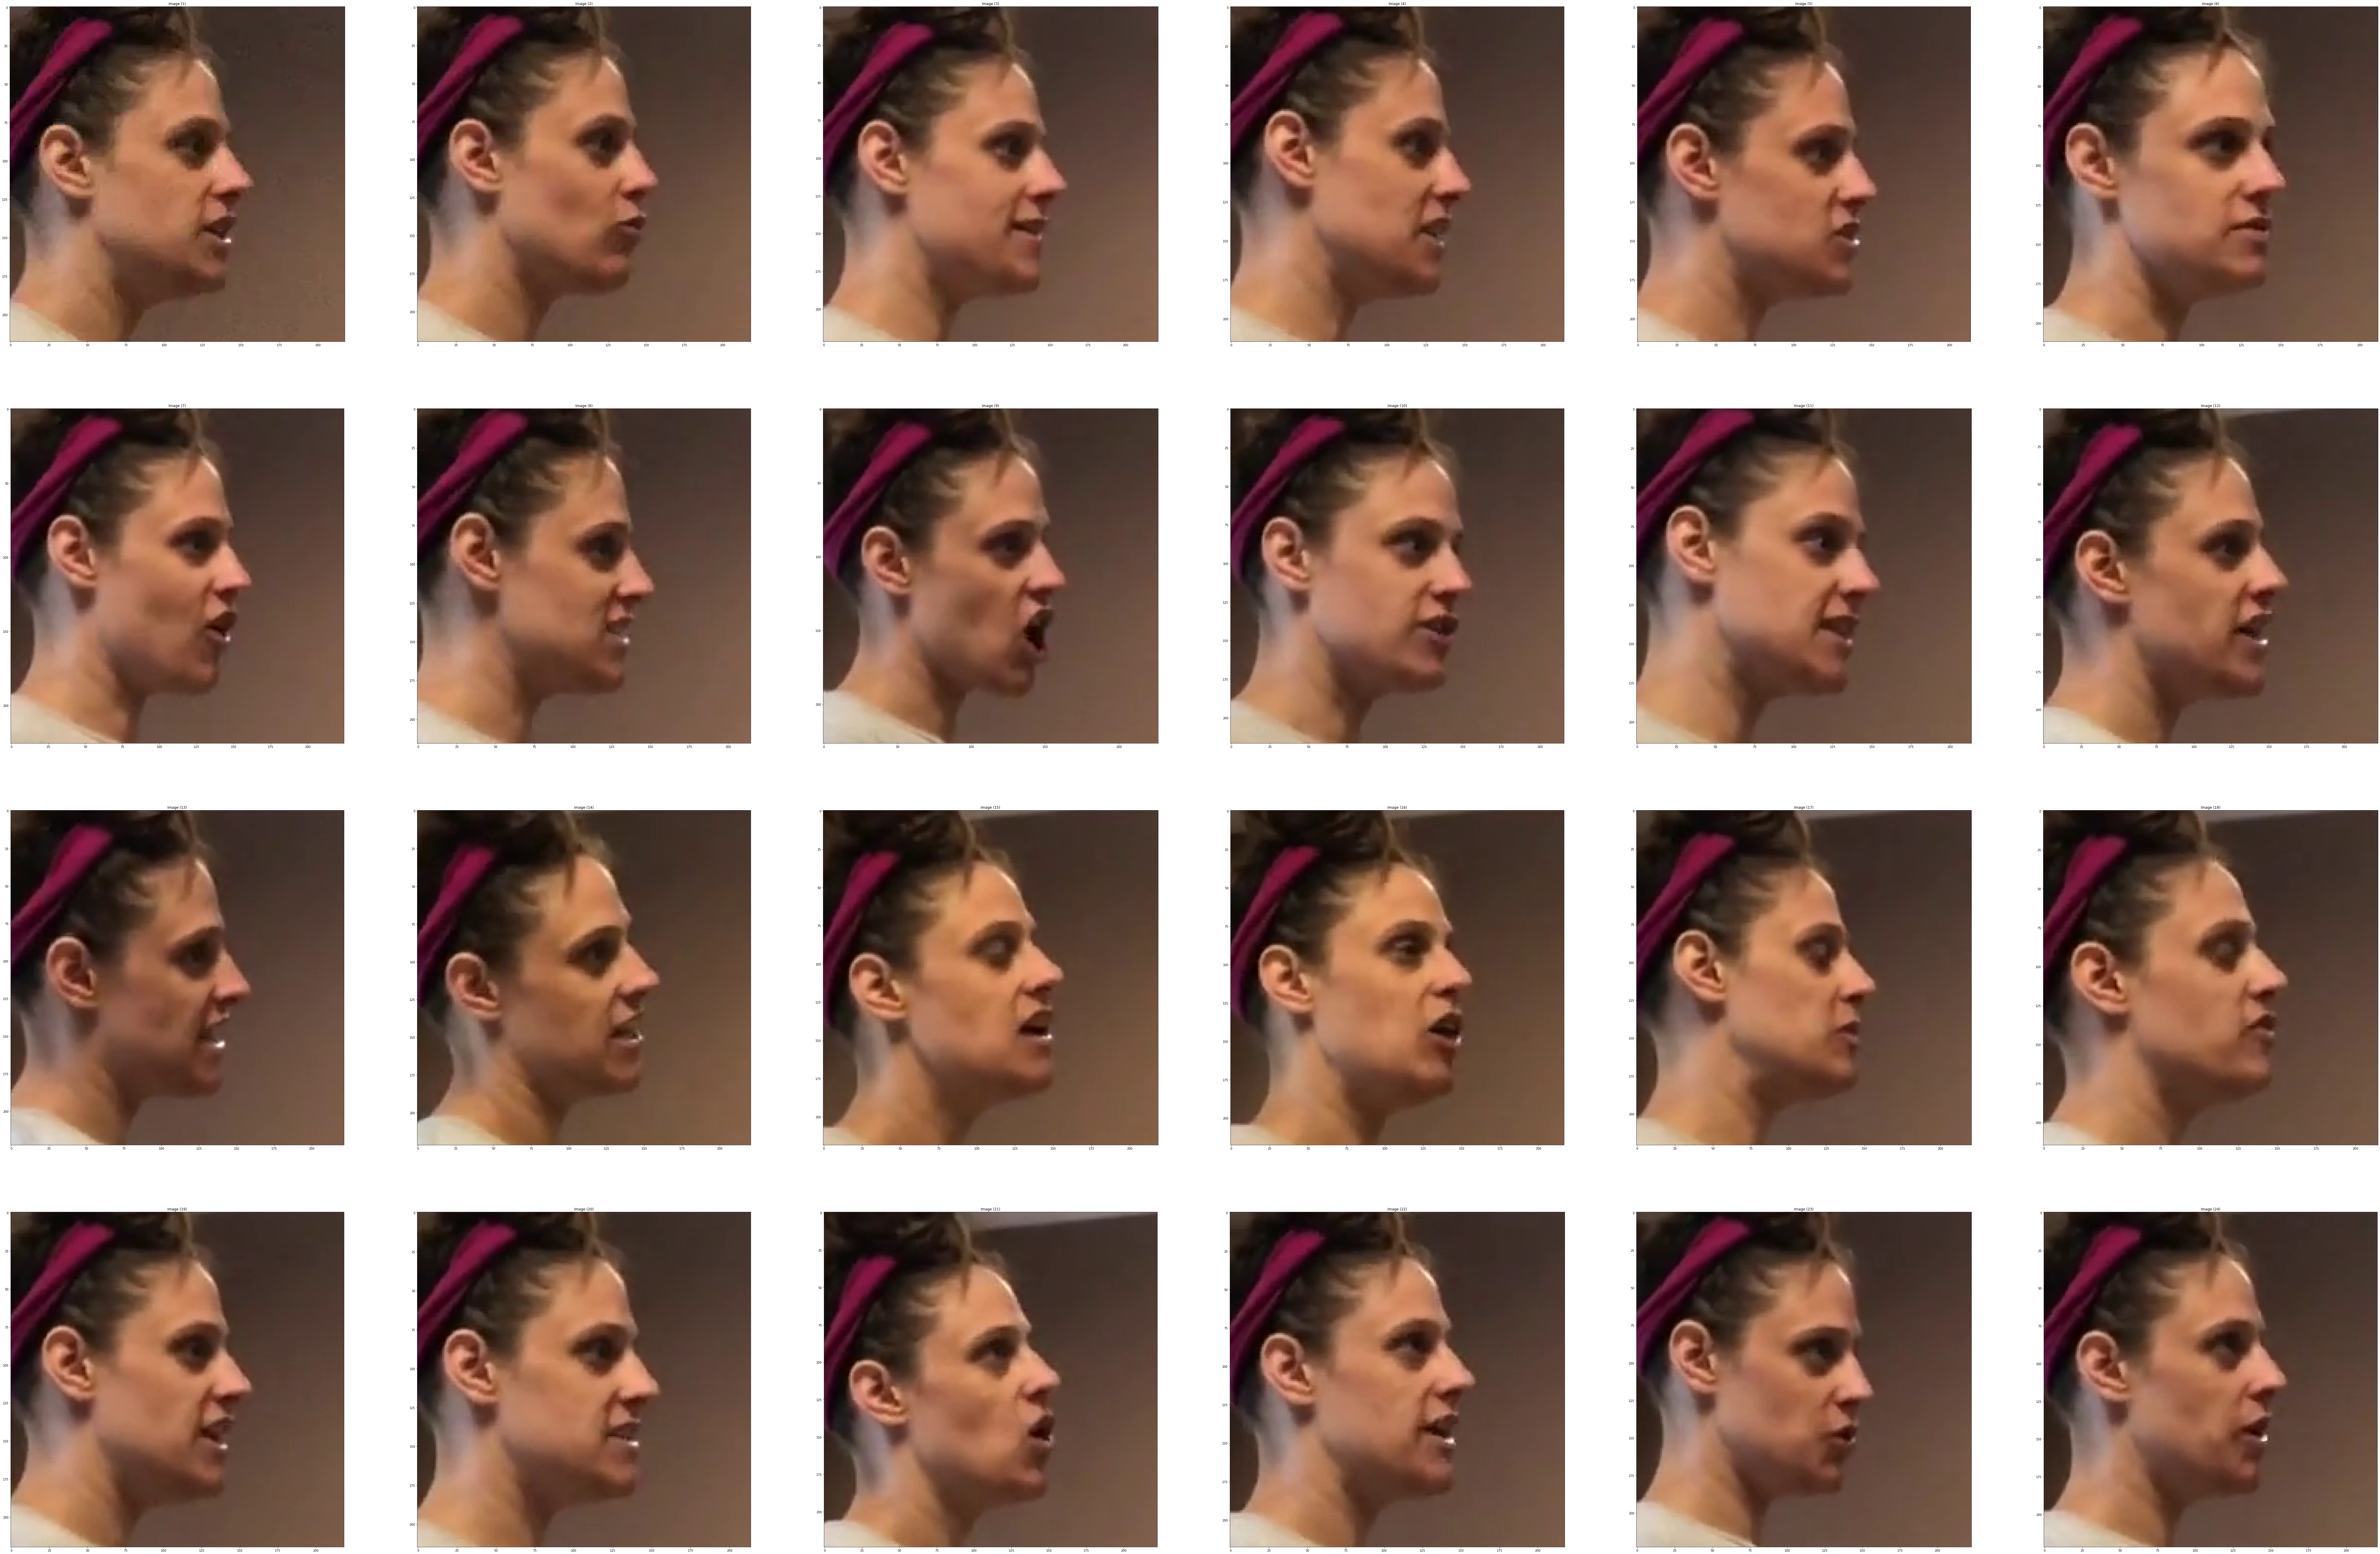

CPU times: user 26.2 s, sys: 1.98 s, total: 28.2 s
Wall time: 8 s


In [20]:
%%time
i += 1

num_frames = 24
out = []
avg_size = 0

label = get_text_label(i, df)
print('%d: %s' % (i, label))

sample = get_sample(i, df, reader, n_frames=num_frames)
dets = detect(sample, net, cfg, device)

for f in range(num_frames):
    num_faces = len(dets[f])
    
    if num_faces == 0:
        print(f'No faces in {f} frame')
    elif num_faces > 1:
        print(f'{num_faces} faces in {f} frame with probs:')
        scores = [d[-1] for d in dets[f]]
        print(scores)
        
    for det in dets[f]:
        cropped = crop_face(sample[f], det[:4])
        out.append(cropped)
        avg_size += cropped.shape[0]
        
avg_size /= num_frames
print('Avg size: %.1f' % avg_size)
cols = math.ceil(len(dets) / 6)
show_images(out, cols=cols)

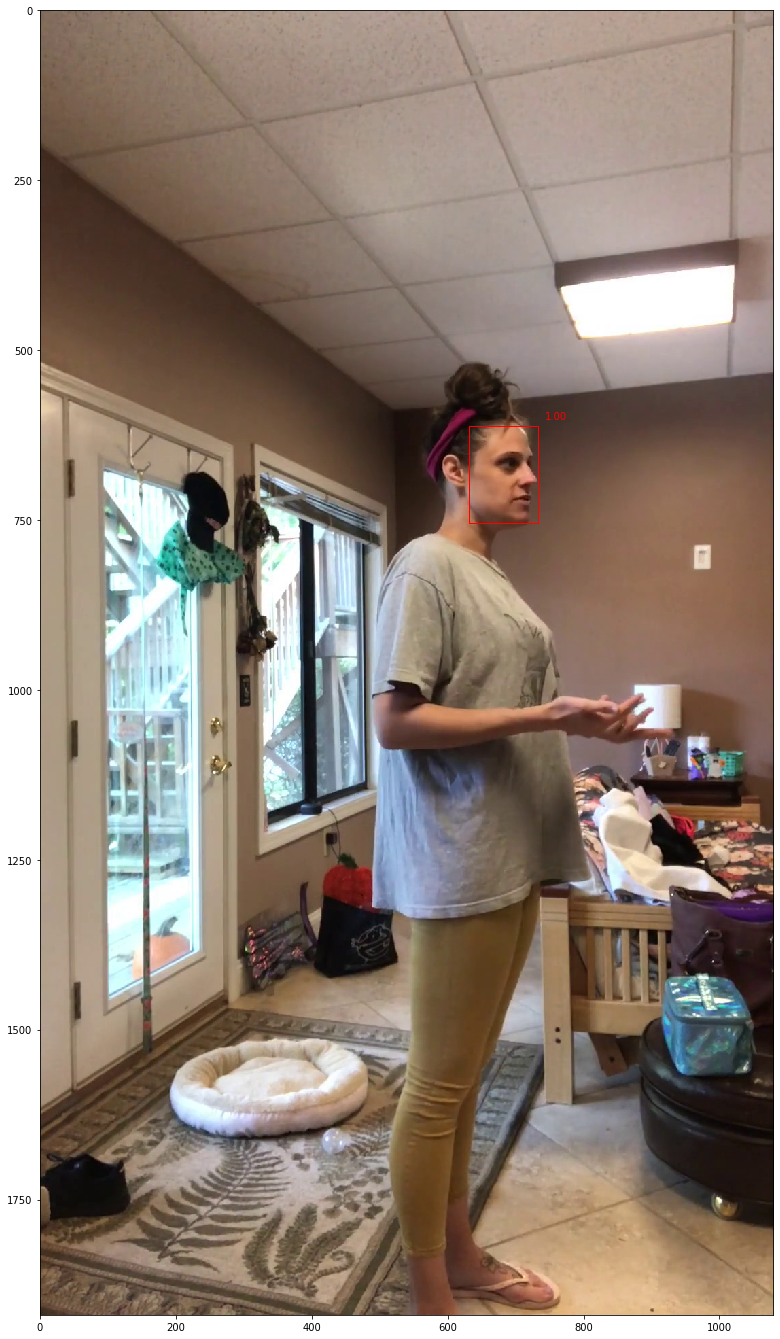

In [21]:
f = 5
show_image_bbox(sample[f], boxes=dets[f], figsize=(24, 24))